In [1]:
import sympy as smp
import numpy as np
import scipy as sp
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

In [2]:
# smp.eye()
# smp.Array([])
# smp.tensorproduct(Tensor 1, Tensor 2)
# smp.tensorcontraction(Tensor, (first index, second index))

# <center>Defining Metrics Tensors, Energy-Momentum Tensors and Variables<center>

## The Variables

In [3]:
m, sigma, C_0, alpha, beta, r_s, M, t, r, theta, phi, tau, x, y, z, l, E = smp.symbols('m sigma C_0 alpha beta r_s M t r theta phi tau x y z l E', float = True)

## The Metric Tensors

#### A General Spherically Symmetric Metric

In [4]:
A , B = smp.symbols('A B', cls = smp.Function)
A = A(r)
B = B(r)


Sphecally_Symmetric_Metric = { 'Metric' : smp.MutableDenseNDimArray([[-A,0,0,0],
                                                                     [0,B,0,0],
                                                                     [0,0,r**2,0],
                                                                     [0,0,0,r**2*smp.sin(theta)**2]]),
                              
                              'Basis' : smp.Array([t,r,theta,phi]),
                              
                              'Dimention' : 4,
                              
                              'Basis_Parameter' : smp.MutableDenseNDimArray([t, r, theta, phi])}

# <center>Functions of the Objects from Differential Geometry<center>

In general relativity, either:

1. We know the metric to begin with. (From which we can calculate anything we like with it using the functions bellow.)

2. We do not know the metric, but wish to find it. (In which case we must solve Einsteins equations using the functions bellow.)

### Derivative of Rank-2 Tensor

$$\partial_{\mu} g_{\nu \beta}$$

In [5]:
def Derivative(T):
    G = T['Metric']
    N = T['Dimention']
    basis = T['Basis']
    A = smp.MutableDenseNDimArray(smp.zeros(N**3),(N,N,N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                A[i,j,k] = smp.diff(G[j,k],basis[i])
    return A

### Inverse of Rank-2 Tensor

$$ g^{\nu \beta} = (g^{-1})_{\nu \beta}$$

In [6]:
def inv(T):
    G = T['Metric']
    N = T['Dimention']
    basis = T['Basis']
    g_m = G.tomatrix()
    inv_g = g_m.inv()
    A = smp.MutableDenseNDimArray(smp.zeros(N**2),(N,N))
    for i in range(N):
        for j in range(N):
            A[i,j] = inv_g[i, j]
    return A

### The Christoffel Symbols

$$ \Gamma^{\alpha}_{\mu \nu} = \frac{1}{2} g^{\alpha \beta} \left( \partial_{\mu} g_{\nu \beta} + \partial_{\nu} g_{\mu \beta} - \partial_{\beta} g_{\mu \nu} \right) $$

In [7]:
def Gamma(T):
    G = T['Metric']
    N = T['Dimention']
    basis = T['Basis']
    A1 = smp.MutableDenseNDimArray(smp.zeros(N**3),(N,N,N))
    ig = inv(T)
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for d in range(N):
                    A1[i, j, k] += smp.Rational(1, 2)*(ig[d,i])*(smp.diff(G[k,d],basis[j]) + smp.diff(G[d,j],basis[k]) - smp.diff(G[j,k],basis[d]))
            
    
    return A1

### The Covarient Derivatives

Acting on: The Contravariant (1,0) Tensor (Vector) Field 

$$D_{\mu}V^{\nu} = {\partial}_{\mu}V^{\nu} + {\Gamma}^{\nu}_{\mu \alpha}V^{\alpha}$$

In [8]:
def CovariantD10(T, V):
    N = T['Dimention']
    basis = T['Basis']
    C = Gamma(T)
    DV = smp.MutableDenseNDimArray(smp.zeros(N**2),(N,N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                DV[i,j] += smp.Rational(1, N)*smp.diff(V[j],basis[i]) + C[j,i,k]*V[k]
    return DV

Acting on: The Covariant (0,1) Tensor (Vector) Field

$$D_{\mu}V_{\nu} = {\partial}_{\mu}V_{\nu} - {\Gamma}^{\alpha}_{\mu \nu}V_{\alpha}$$

In [9]:
def CovariantD01(T, V):
    N = T['Dimention']
    basis = T['Basis']
    C = Gamma(T)
    DV = smp.MutableDenseNDimArray(smp.zeros(N**2),(N,N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                DV[i,j] += smp.Rational(1, N)*smp.diff(V[j],basis[i]) - C[k,i,j]*V[k]
    return DV

Acting on: Type (2,0) Tensor Field

$$D_{\alpha}T^{\mu \nu} = {\partial}_{\alpha}T^{\mu \nu} + {\Gamma}^{\mu}_{\alpha \gamma}T^{\gamma \nu} + {\Gamma}^{\nu}_{\alpha \gamma}T^{\gamma \mu}$$

In [10]:
def CovariantD20(G, T):
    N = G['Dimention']
    basis = G['Basis']
    C = Gamma(G)
    DT = smp.MutableDenseNDimArray(smp.zeros(N**3),(N,N,N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for p in range(N):
                    DT[i,j,k] += smp.Rational(1, N)*smp.diff(T[j,k],basis[i]) + C[j,i,p]*T[p,k] + C[k,i,p]*T[p,j]
    return DT

Acting on: Type (0,2) Tensor Field

$$D_{\alpha}T_{\mu \nu} = {\partial}_{\alpha}T_{\mu \nu} - {\Gamma}^{\gamma}_{\alpha \mu}T_{\gamma \nu} - {\Gamma}^{\gamma}_{\alpha \nu}T_{\gamma \mu}$$

In [11]:
def CovariantD02(G, T):
    N = G['Dimention']
    basis = G['Basis']
    C = Gamma(G)
    DT = smp.MutableDenseNDimArray(smp.zeros(N**3),(N,N,N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for p in range(N):
                    DT[i,j,k] += smp.Rational(1, N)*smp.diff(T[j,k],basis[i]) - C[p,i,j]*T[p,k] - C[p,i,k]*T[p,j]
    return DT

Acting on: Type (1,1) Tensor Field

$$D_{\alpha}T^{\mu}_{\nu} = {\partial}_{\alpha}T^{\mu}_{\nu} + {\Gamma}^{\mu}_{\alpha \gamma}T^{\gamma}_{\nu} - {\Gamma}^{\gamma}_{\alpha \nu}T^{\mu}_{\gamma}$$

In [12]:
def CovariantD11(G, T):
    N = G['Dimention']
    basis = G['Basis']
    C = Gamma(G)
    DT = smp.MutableDenseNDimArray(smp.zeros(N**3),(N,N,N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for p in range(N):
                    DT[i,j,k] += smp.Rational(1, N)*smp.diff(T[j,k],basis[i]) + C[j,i,p]*T[p,k] - C[p,i,k]*T[j,p]
    return DT

### The Riemannm Tensor

$$ R^{ \rho}_{\sigma \mu \nu}  = {\partial}_{\mu} {\Gamma}^{\rho}_{\nu \sigma} - {\partial}_{\nu} {\Gamma}^{\rho}_{\mu \sigma} + {\Gamma}^{\rho}_{\mu \lambda}{\Gamma}^{\lambda}_{\nu \sigma} - {\Gamma}^{\rho}_{\nu \lambda}{\Gamma}^{\lambda}_{\mu \sigma} $$

In [13]:
def Riemann(M):
    T = M['Metric']
    N = M['Dimention']
    basis = M['Basis']
    G = Gamma(M)
    R = smp.MutableDenseNDimArray(smp.zeros(N**4),(N,N,N,N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for p in range(N):
                    for d in range(N):
                        R[i, j, k, p] += smp.Rational(1, N)*(smp.diff(G[i,p,j],basis[k])-
                                                             smp.diff(G[i,k,j],basis[p]))+(G[i,k,d]*G[d,p,j]-G[i,p,d]*G[d,k,j])

    
    return R

Purely covariant Riemann tensor:
    
$$ R_{\rho \sigma \mu \nu} = g_{\rho \alpha}R^{\alpha}_{\sigma \mu \nu}$$

In [14]:
def CovRiemann(T):
    G = T['Metric']
    N = T['Dimention']
    basis = T['Basis']
    R = Riemann(T)
    RL = smp.MutableDenseNDimArray(smp.zeros(N**4),(N,N,N,N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for p in range(N):
                    for d in range(N):
                        RL[i,j,k,p] += G[i,d]*R[d,j,k,p]
    return RL

### The Ricci Tensor

$$ R_{\mu \nu} = g^{\alpha \beta} R_{\alpha \mu \beta \nu}$$

In [15]:
def Ricci(T):
    G = T['Metric']
    N = T['Dimention']
    basis = T['Basis']
    ig = inv(T)
    RL = CovRiemann(T)
    Ric = smp.MutableDenseNDimArray(smp.zeros(N**2),(N,N))
    for i in range(N):
        for j in range(N):
            for d in range(N):
                for s in range(N):
                    Ric[i,j] += ig[d,s]*RL[d,i,s,j]
    return Ric

### The Ricci Scalar

$$ R = g^{\mu \nu}R_{\mu \nu}$$

The Following function will take in the Metric and return the solution for the following equation:

$$ R = g^{\mu \nu}R_{\mu \nu} = 0$$

Remark: This is in fact the einstein equation for: $T_{\mu \nu}=0$ and $\Lambda = 0$

In [16]:
def RiccScalar(T):
    G = T['Metric']
    N = T['Dimention']
    basis = T['Basis']
    R = Ricci(T)
    ig = inv(T)
    S = float()
    for d in range(N):
        for s in range(N):
            S = ig[d,s]*R[d,s]
    return S

### The Curvature Scalar

$$ S = g^{\sigma \alpha}g^{\rho \beta}g^{\mu \gamma}g^{\epsilon \nu}R_{\alpha \beta \mu \nu} R_{\sigma \rho \gamma \epsilon} = R^{\sigma \rho \gamma \epsilon}R_{\sigma \rho \gamma \epsilon}$$

In [17]:
def CurvScalar(T):
    G = T['Metric']
    N = T['Dimention']
    basis = T['Basis']
    R = CovRiemann(T)
    ig = inv(T)
    CS = float()
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for p in range(N):
                    for d in range(N):
                        for n in range(N):
                            for s in range(N):
                                for t in range(N):
                                    CS += ig[i,j]*ig[k,p]*ig[d,n]*ig[s,t]*R[i,k,d,s]*R[j,p,d,s]
    return CS

### The Geodesic Equation

$$ \frac{d^2x^{\mu}}{d\tau^2} + {\Gamma}^{\mu}_{\alpha \beta} \frac{dx^{\alpha}}{d\tau}\frac{dx^{\beta}}{d\tau} = 0$$

In [18]:
def Geodesic(T):
    N = T['Dimention']
    basis = T['Basis']
    P = T['Basis_Parameter']
    C = Gamma(T)
    Geo = smp.MutableDenseNDimArray(smp.zeros(N),(N))
    for i in range(N):
        for j in range(N):
            for k in range(N):
                Geo[[i]] += smp.Rational(1, N**2)*(smp.diff(basis[i], tau, tau)) + C[i, j, k]*(smp.diff(basis[j], tau))*(smp.diff(basis[k], tau))
    
    return Geo

### The Euler-Lagrange Equation in GR

<b> First we define the Lagrangian above:
    

$$ L = \sqrt{-g_{\mu \nu}\frac{dx^{\mu}}{d\tau}\frac{dx^{\nu}}{d\tau}} $$

In [19]:
def Lagrangian(T):
    G = T['Metric']
    N = T['Dimention']
    basis = T['Basis']
    P = T['Basis_Parameter']
    L = float()
    for i in range(N):
        for j in range(N):
            L += - G[i,j]*smp.diff(P[i], tau)*smp.diff(P[j], tau)
    
    return smp.sqrt(L)

<b> Second, we define the Euler-Lagrange Equations:
    
$$ \frac{\partial L}{\partial x^{\alpha}} - \frac{d}{d\tau}\frac{\partial L}{\partial \frac{\partial x^{\alpha}}{\partial \tau}}=0$$
    
Note: To greatly simplify these equations, the code sets the lagrangian equal to 1 in each iteration of calculation. We are allowed to do this because we can arbitrarily set the length of the geodesic equation to be what we like. The path itself is what we are interested in, the length of the path is really just not so important. All we are doing by setting $L=1$ at the end of our calculations is setting the length of our geodesic curve, parametrixzed by $\tau$ to be $length = 1$ 

In [20]:
def Euler_Lagrange(L, T):
    N = T['Dimention']
    basis = T['Basis']
    P = T['Basis_Parameter']
    
    dpdt = smp.MutableDenseNDimArray(smp.zeros(N),(N))
    for i in range(N):
        dpdt[[i]] = smp.diff(P[i],tau)
    
    A = smp.MutableDenseNDimArray(smp.zeros(N),(N))
    B = smp.MutableDenseNDimArray(smp.zeros(N),(N))
    for i in range(N):
        B[[i]] = smp.diff(L, dpdt[i])
    for i in range(N):
        A[[i]] = B[i].subs(L, 1)
    
    
    C = smp.MutableDenseNDimArray(smp.zeros(N),(N))
    D = smp.MutableDenseNDimArray(smp.zeros(N),(N))
    for i in range(N):
        C[[i]] = smp.diff(L, P[i])
    for i in range(N):
        D[[i]] = C[i].subs(L, 1)
    
    La = smp.MutableDenseNDimArray(smp.zeros(N),(N))
    for i in range(N):
            La[[i]] = D[i] - smp.diff(A[i], tau)
    
    return La

### The Einstein Field Equations

$$ R_{\mu \nu} - \frac{1}{2} g_{\mu \nu} R + g_{\mu \nu} \frac{\Lambda}{c^2} = \frac{8 \pi G_N}{c^4} T_{\mu \nu}$$

However, firstly we are working with the units $c=1$ and secondly, we must rearange the equation into a form which allows us to create a SymPy function for it and furthermore, we will only work with metrics of dimention 4 with this equation in particular:

$$ R_{\mu \nu} - \frac{1}{2} g_{\mu \nu} R + g_{\mu \nu}\Lambda - 8 \pi G T_{\mu \nu} = 0$$

Important remark: Before using this function, make sure you have the right form of the energy momentum you are trying to find the metric solution for.
Exmaple: Suppose you wish to find the metric for a charged black hole, do not mistake the Stress-Energy Tensor $T_{\mu \nu}$ with the electromagnetic tensor $F_{\mu \nu}$. If you are familiar with physcis, you will know one is determined from the other by the following equation:

$$T_{\mu \nu} = F_{\mu \lambda} F_{\nu}^{\lambda} - \frac{1}{4}g^{\mu \nu}F_{\alpha \beta}F^{\alpha \beta}$$

In [21]:
def Einstein(G, E, C):
    g = G['Metric']
    N = G['Dimention']
    basis = G['Basis']
    Ric = Ricci(G)
    Ein = smp.MutableDenseNDimArray(smp.zeros(N**2),(N,N))
    for i in range(N):
        for j in range(N):
                    Ein[i,j] += ig[d,s]*RL[d,i,s,j]
    return Ric

# <center>Calculating the Schwarzschild solution<center>

In [22]:
eq1 = Ricci(Sphecally_Symmetric_Metric)[0,0].simplify()
eq2 = Ricci(Sphecally_Symmetric_Metric)[1,1].simplify()
eq3 = Ricci(Sphecally_Symmetric_Metric)[2,2].simplify()
eq4 = Ricci(Sphecally_Symmetric_Metric)[3,3].simplify()

We have the following:

$R_{t t} = 0 \Leftrightarrow $ Equation 1: $$ \frac{A''}{2B} - \frac{A'B'}{4B^2} - \frac{(A')^2}{4AB} + \frac{A'}{rB}= 0$$

$R_{r r} = 0 \Leftrightarrow $ Equation 2: $$ \frac{A''}{2A} + \frac{A'B'}{4AB} + \frac{(A')^2}{4A^2} + \frac{B'}{rB} = 0$$

$R_{\theta \theta} = 0 \Leftrightarrow $ Equation 3: $$ \frac{rB}{2B^2} - \frac{rA'}{2AB} + 1 + \frac{1}{B} = 0$$

$R_{\phi \phi} = 0 \Leftrightarrow $ Equation 4: $$ \sin^2(\theta) \left(\frac{rAB'}{2AB^2} - \frac{rBA'}{2AB^2} + 1 - \frac{1}{B} \right) = 0$$

It is easy to see how one might simplify these, but lets skip ahead and combine some of these to get to what we want. (Expressions of $A(r)$ and $B(r)$.) Namely, we will do the following to Equation 1 and Equation 2:

Define a new Equation 5: $$ \left( B \times Equation1 + A \times Equation2 \right) \times (rB)$$

In [23]:
eq5 = ((eq1*B + eq2*A)*(r*B)).simplify()

We find Equation 5: $$A(r)\frac{dB(r)}{dr} - B(r)\frac{dA(r)}{dr}  = 0$$

Which we can solve directly:

In [24]:
B_solution = smp.dsolve(eq5, B)

We find the following from solving Equation 5:

$$B(r) = \frac{C_0}{A(r)}$$

Which we can now substitute into Equation 3 or Equation 4, in this case we substitute into Equation 3. We will call it Equation 6:

In [25]:
eq6 = eq3.subs(B, C_0/A).simplify()

Equation 6:

$$ 1 - A(r) - r \frac{dA(r)}{dr} = 0$$

We are now at a point from which we can explicitly solve to find an exact function for $A(r)$:

In [26]:
sol_A = smp.dsolve(eq6, A)

Finnaly we have a solution to what we want. We find two constants, which we can combine into one and find:

$$ A(r) = 1 + \frac{C_{1}}{r}$$

To find the constant $C_{1}$ requires physical boundary conditions. The way we find it is by substituting the above into the original metric, to find:


$$ g_{\mu \nu} = 
\begin{pmatrix}
1 + \frac{C_{1}}{r} & 0 & 0 & 0\\
0 & \frac{1}{1 + \frac{C_{1}}{r}} & 0 & 0\\
0 & 0 & r^2 & 0 \\
0 & 0 & 0 & r^2\sin^2(\theta)
\end{pmatrix} $$

We must make the following requirement:

<center>Acceleration in flat-metric-approximation near body of mass M = Newtonian acceleration of gravity near body of mass M<center>
    
Mathematically, this is what we do:
    
In the limit $r \rightarrow \infty$
    
$$ \frac{d^2r}{d\tau^2} = \Gamma^{r}_{t t} c c  \Leftrightarrow ma = - \frac{GMm}{r^2}$$
    
In comparing these two we can find that in the limmit $r \rightarrow \infty$ we find:
    
$$ - C_1 = r_s = \frac{2GM}{c^2} $$
    
And we therefore find the Schwarzchild Solution in it's full wonderful glory as:
    
$$ g_{\mu \nu} = 
\begin{pmatrix}
1 - \frac{r_s}{r} & 0 & 0 & 0\\
0 & \frac{1}{1 - \frac{r_s}{r}} & 0 & 0\\
0 & 0 & r^2 & 0 \\
0 & 0 & 0 & r^2\sin^2(\theta)
\end{pmatrix} $$
    
And we now write this very metric in Sympy form so that we can calculate more interesting physical things:

#### The Schwarzschild Metric

In [27]:
t_p, r_p, theta_p, phi_p = smp.symbols('t_p r_p theta_p phi_p', cls = smp.Function)

t_p = t_p(tau)
r_p = r_p(tau)
theta_p = theta_p(tau)
phi_p = phi_p(tau)

Schild = { 'Metric' : smp.MutableDenseNDimArray([[-(1 - (r_s)/(r_p)),0,0,0],
                                                 [0,1/(1 - (r_s)/(r_p)),0,0],
                                                 [0,0,r_p**2,0],
                                                 [0,0,0,r_p**2*smp.sin(theta_p)**2]]),
          'Basis' : smp.Array([t_p,r_p,theta_p,phi_p]),
          
          'Dimention' : 4, 
          
          'Basis_Parameter' : smp.MutableDenseNDimArray([t_p, r_p, theta_p, phi_p]) }

<b>Remark:

Because each variable in this metric will be sooner or later be parammetrised by one variable to find worldlines and geodesics in this space, we have written the metric itself not with Sympy variables but rather with Sympy functions.

# <center>Calculating & Animating Orbital Equations<center>

In curved spaces, particles follow paths known as geodesics, where massive and massless particles do, of course, have slightly different geodesics. Given we now want to describe moving particles in curved spaces, geodesic equations are indispensable. There are a few different ways the geodesic can be derived, an elegant method is by extremizing the proper time:

$$ \tau_{AB} = \int^{A}_{B} \sqrt{-g_{\mu \nu}\frac{dx^{\mu}}{d\tau}\frac{dx^{\nu}}{d\tau}} $$

A to B is the proper time A
elapsed in space-time and we will find it convenient later to make it a unit length.

In [28]:
L = Lagrangian(Schild)

The Lagrangian equation above is given by:

$$L = \sqrt{ \left( 1 - \frac{r_s}{r} \right) \dot{t}^2 - \left( 1 - \frac{r_s}{r} \right)^{-1}  \dot{r}^2 - r^2 \dot{\theta}^2 - r^2\sin^2(\theta) \dot{\phi}^2}$$

<b> Next, we solve Euler-Lagrange for $L$
    
We now wish to solve the equation of motions, by substituting our lagrangian above into the Euler-Lagrange Equations:

$$ \frac{\partial L}{\partial x^{\alpha}} - \frac{d}{d\tau}\frac{\partial L}{\partial \dot{x^{\alpha}}}=0$$

We have a 4-Dimentional spacetime and therefore there will be 4 differential equations:

1. We can create an extra equation given above for $L=1$
2. The Euler-Lagrange for $t$
3. The Euler-Lagrange for $r$
4. The Euler-Lagrange for $\theta$
5. The Euler-Lagrange for $\phi$

<b>1. The extra Euler-Lagrange

By setting this equation to one $L=0$ we can treat it as an extra differential equation of motion. The reason we are allowed to do this is because $L$ represents the length of the parametrised path we will find by solving Euler-Lagrange equations. As the actual length is arbitrary non-zero value dependent on the parameter itself, we can choose any non-zero positive value, in this case we choose $1$.

In [29]:
E0 = 1 - Lagrangian(Schild)**2

This Equation of motion we will call E0 and it is given by:

$$1 = \left( 1 - \frac{r_s}{r} \right) \dot{t}^2 - \left( 1 - \frac{r_s}{r} \right)^{-1}  \dot{r}^2 - r^2 \dot{\theta}^2 - r^2\sin^2(\theta) \dot{\phi}^2$$

Important Remark: This will be used as a "Main Equation" meaning it is this equation which we will substitute the other differential equations into, to find a final differential equation of the form: 

$$E = KE + V_{eff}$$

<b>2. The Euler-Lagrange for t
    
We do not need to emmediatly use our Euler-Lagrange function to find this equation. Notice that since L is completly independent of time $t$
    
This means our E-L reduces to:
    
$$ \frac{d}{d\tau}\frac{\partial L}{\partial \dot{t}}=0 \Rightarrow \frac{\partial L}{\partial \dot{t}} = Constant$$

We write this constant as Energy $E$ and we find our first equation of motion as:

In [30]:
t_d = (E)/(1 - r_s/r_p)

$$ \frac{dt}{d\tau} = \frac{E}{1 - \frac{r_s}{r}}$$

<b>3. The Euler-Lagrange for $r$

In [31]:
Er = Euler_Lagrange(L, Schild)[1]

Which we find to be:

$$ 0 = \left( 1 - \frac{r_s}{r} \right)^{-1} \frac{d^2r}{d\tau^2} - \frac{r_s}{2r^2 \left( 1 - \frac{r_s}{r} \right)^2} \left( \frac{dr}{d\tau} \right)^2  + \frac{r_s}{2r^2} \left( \frac{dt}{d\tau} \right)^2 - r \left( \frac{d\phi}{d\tau} \right)^2 - r\sin^2(\theta) \left( \frac{d\phi}{d\tau} \right)^2$$

From which we can rearange to find an explicity equation for $\frac{d^2r}{d\tau^2} = ...$

In [32]:
r_dd = smp.solve(Er, smp.diff(r_p, tau, tau))[0]

<b>4. The Euler-Lagrange for $\theta$

In [33]:
Etheta = Euler_Lagrange(L, Schild)[2]

Which we find to be:

$$ 0 = r^2 \left( \frac{d^2\theta}{d\tau^2} \right) + 2r \left( \frac{dr}{d\tau} \right) \left( \frac{d\theta}{d\tau} \right) - r^2\sin(\theta)\cos(\theta) \left( \frac{d\phi}{d\tau} \right)^2$$

From which we can rearange to find an explicity equation for $\frac{d^2\theta}{d\tau^2} = ...$

In [34]:
theta_dd = smp.solve(Etheta, smp.diff(theta_p, tau, tau))[0]

<b>5. The Euler-Lagrange for $\phi$
    
Just like in the case for time-component equation, $L$ is completly independent of $\phi$, which again, emediatly reduces the Euler-Lagrange equation to the form:
    
$$ \frac{d}{d\tau}\frac{\partial L}{\partial \dot{\phi}}=0 \Rightarrow \frac{\partial L}{\partial \dot{\phi}} = Constant$$

We write this constant as Angular Momentum, dented by $l$ and we find our phi equation of motion to be:
    
$$ \frac{d\phi}{d\tau} = \frac{l}{r^2\sin^2(\theta)} $$

In [35]:
phi_d = l/(r_p**2*smp.sin(theta_p)**2)

However, we can also immediatly find the equation for $\frac{d^2\phi}{d\tau^2} = ...$

In [36]:
phi_dd = smp.solve(Euler_Lagrange(L, Schild)[3].subs(theta_p, smp.pi/2).simplify(), smp.diff(phi_p, tau, tau))[0].simplify() # Please mind the messiness

<b> Physics Simplifications:

Before continue with the maths let’s think about some physics:
    
Due to conservation of angular momentum, we know planets orbit on fixed planes. This statement comes from Newtonian physics, however, it also applies to the Schwarzchild spacetime geometry, as can be seen from the maths by the independence of $\phi$ in our Lagrangian $L$ derived from the Schwarzchild metric itself. The variable $\theta$ determines the plane of the orbital motion. The exact same physics will happen on any orbital plane we choose to do our calculations. Therefore, for mathematical simplicity, we make the choice:
    
$\theta = \frac{\pi}{2}$, consequently $\sin(\frac{\pi}{2}) = 1$ and  $\frac{d\theta}{d\tau}=0$.

<b> Substitutions:
    
First: We have explicit forms for $\frac{d\phi}{d\tau}$ and $\frac{dt}{d\tau}$ which we can substitute into our first equation $L=1$ (E0)
    
Second: We have made the choice $\theta = \frac{\pi}{2}$ which we can also use to greatly simlify $L=1$ (E0) from any dependence of $\theta$
    
After making these substitutions, we will call the resulting equation E1

In [37]:
E1 = E0.subs([(smp.diff(t_p, tau),t_d), (smp.diff(phi_p, tau), phi_d), (theta_p, smp.pi/2)]).simplify()

This new differential equation E1, is given by:

$$ 0 = - \frac{E^2}{2} + \frac{1}{2} + \frac{1}{2}\left( \frac{dr}{d\tau} \right)^2 - \frac{r_s}{2r} + \frac{l^2}{2r^2} - \frac{r_sl^2}{2r^3} $$

Which can be rearranged to the form

$$ \left( \frac{E^2}{2} \right) = \frac{1}{2}\left( \frac{dr}{d\tau} \right)^2 + \frac{1}{2} - \frac{r_s}{2r} + \frac{l^2}{2r^2} - \frac{r_sl^2}{2r^3} $$

Which is clearly of the same shape as

$$ E = KE + V_{eff} $$

And we find the very usefull term:

$$ V_{eff} = \frac{1}{2} + \frac{l^2}{2r^2} - \frac{r_s}{2r} - \frac{r_sl^2}{2r^3} $$

### Animating Orbital Equations

There are many ways to go about animating orbital equations. We will do the most straighforeward method, to arrive at the answer quickest. From a physics standpoint, our solution can be considered as a Newtonian approximation to the General Relativistic orbit. This is not to say we do not have all the relevant information and equations at hand to calculate all the precise relativistic GRsolutions. However, that rout is much longer, so for the sake of "getting to the point" we will make due with the Newtonian approximation, which still reproduces the identifying feature of a Relativistic orbit, known as precession of the perihelion of orbits. What I mean by Newtonian approximation, is we will solve the classical Euler-Lagrange equation with the effective potential calculated above using GR.

We have non-relativistic Kinetic Energy given by:

$$ KE = \frac{1}{2}m \left( \left( \frac{dr}{dt} \right)^2 + r^2 \left( \frac{d\phi}{dt} \right)^2 \right) $$

The effective potential is given by 

$$ V_{eff} = \frac{1}{2} + \frac{l^2}{2r^2} - \frac{r_s}{2r} - \frac{r_sl^2}{2r^3} $$

In [38]:
t, m, M, l, r_s = smp.symbols('t m M l r_s')
r, theta = smp.symbols('r theta', cls = smp.Function)

In [39]:
r = r(t)
theta = theta(t)

In [40]:
drdt = smp.diff(r, t)
dthetadt = smp.diff(theta, t)

$$L = KE - V$$

Kinetic Energy $KE$:

In [41]:
KE = smp.Rational(1,2)*m*((drdt**2) + (r**2)*(dthetadt**2))

Potential Energy $V$:

In [42]:
V = 1/2 + (l**2)/(2*r**2) - (r_s)/(2*r) - (r_s*l**2)/(2*r**3)
V

-l**2*r_s/(2*r(t)**3) + l**2/(2*r(t)**2) - r_s/(2*r(t)) + 0.5

Now, we put these together to find the Lagrangian $L$:

In [43]:
L = KE - V

Define the Euler-Lagrange equation, we want equations of $r$ and $\theta$:

$$ \frac{\partial L}{\partial x^{\mu}} - \frac{d}{dt}\frac{\partial L}{\partial \dot{x^{\mu}}} = 0  $$

In [44]:
Er = smp.diff(L, r) - smp.diff( smp.diff(L, drdt),t)
Etheta = smp.diff(L, theta) - smp.diff( smp.diff(L, dthetadt),t)

Now we solve for the equations:
    
$\frac{d^2r}{dt^2} = ...$

In [45]:
d2rdt2 = smp.solve(Er, smp.diff(r, t, t))[0]
d2rdt2

(-3*l**2*r_s/2 + l**2*r(t) + m*r(t)**5*Derivative(theta(t), t)**2 - r_s*r(t)**2/2)/(m*r(t)**4)

$\frac{d^2{\theta}}{dt^2} = ...$

In [46]:
d2thetadt2 = smp.solve(Etheta, smp.diff(theta, t, t))[0]
d2thetadt2

-2*Derivative(r(t), t)*Derivative(theta(t), t)/r(t)

We have two differential equations and we wish to convert them to four first order ODE's

Define:

$\dot{r} = z_1$

$\dot{\theta} = z_2$

Our four ODE's are:

$\dot{r} = z_1$

$\dot{z_1} = ...$

$\dot{\theta} = z_2$

$\dot{z_2} = ...$


In [47]:
dz1dt_f = smp.lambdify((t, m, M, l, r_s, r, drdt, dthetadt), d2rdt2)
dz2dt_f = smp.lambdify((t, m, M, l, r_s, r, drdt, dthetadt), d2thetadt2)
drdt_f = smp.lambdify(drdt, drdt)
dthetadt_f = smp.lambdify(dthetadt, dthetadt)

Next, we define $S = (r, z_1, \theta, z_2)$ from which we can differentiate to find:

$$ \frac{dS}{dt} = (\dot{r}, \dot{z_1}, \dot{\theta}, \dot{z_2}) $$

In [48]:
def dSdt(S, t, m, M, l, r_s):
    r, z1, theta, z2 = S
    return [drdt_f(z1),
           dz1dt_f(t, m, M, l, r_s, r, z1, z2),
           dthetadt_f(z2),
           dz2dt_f(t, m, M, l, r_s, r, z1, z2)]

In [99]:
t = np.arange(0, 400, 0.05)
m = 1
l = 0.125
r_s = 100
S_0 = [8, 1, 0, 0.125]
args = (m, M, l, r_s)
ans = integrate.odeint(dSdt, S_0 ,t=t, args = args)

In [100]:
rd = ans.T[0]
drdtd = ans.T[1]
thetad = ans.T[2]
dthetadtd = ans.T[3]

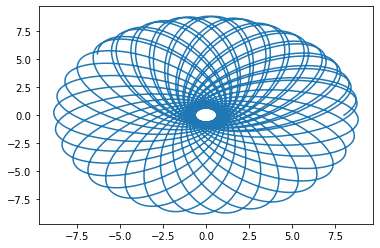

In [101]:
def get_xy_data(t, r, theta):
    xt = r*np.cos(theta)
    yt = r*np.sin(theta)
    return (xt, yt)
x1, y1 = get_xy_data(t, ans.T[0], ans.T[2])
plt.plot(x1, y1)

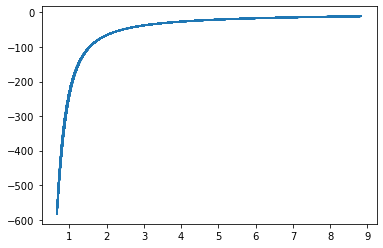

In [102]:
m = 1
l = 1.125
r_s = 200
V = 1/2 + (l**2)/(2*rd**2) - (r_s)/(2*rd) - (r_s*l**2)/(2*rd**3)
plt.plot(rd, V)

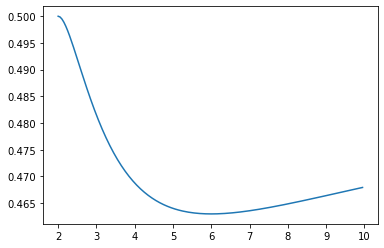

In [103]:
l = 2
r_s = 1

x = np.arange(2, 10, 0.05)
y = 1/2 + (l**2/(2*x**2)) - (r_s)/(2*x) - (r_s*l**2)/(2*x**3)
plt.plot(x, y)

Then we can animate:

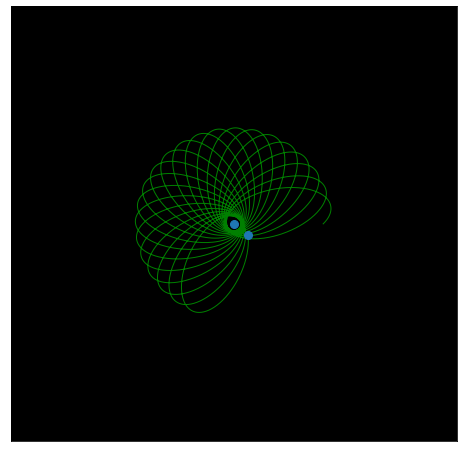

In [104]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
xdata = []
ydata = []
ln2, = plt.plot([],[], color = 'g', lw=1,)
ln1, = plt.plot([],[],'o', lw=3, markersize = 8)
ax.set_ylim(-20, 20)
ax.set_xlim(-20, 20)

def animate(i):
    xdata.append(x1[i])
    ydata.append(y1[i])
    ln2.set_data(xdata, ydata)
    ln1.set_data([0, x1[i]],[0, y1[i]])

ani = animation.FuncAnimation(fig, animate, frames = 4000, interval=50)
ani.save('pen.gif', writer = 'pillow', fps = 30)